<h4>Машинне навчання | Лабораторна робота 1 | Рибчинчук Вадим ПП41</h4>
Додавання бібліотек pandas, torch і так далі та завантаження даних з файлу. Визначення ознак та міток.

In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Завантаження CSV файлу
data = pd.read_csv('dataset_8.csv')

# Виділяємо ознаки та мітки(цільові значення)
X = data[['feature_1', 'feature_2', 'feature_3']].values  # Вхідні ознаки
y = data['target'].values  # Мітки

# Вивести кілька перших рядків, щоб подивитись на структуру даних
print("Dataset")
print(data.head())

   feature_1  feature_2  feature_3     target
0   0.902184   2.613016   2.403261   1.663145
1   9.075906   7.003725   8.895834  60.879930
2   5.474543   0.579361   8.659578  33.838535
3   6.365969   1.851426   0.695562   5.193325
4   1.209075   8.826844   2.063858  35.834498


Розбивання отриманих даних на dataset для тренування та тестування.

In [4]:
# Перетворення в тензори
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Розбиваємо дані на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Створюємо датасети для тренувальних і тестових даних
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Пакетний завантажувач даних
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Створення початкової моделі.

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_function):
        super(NeuralNetwork, self).__init__()
        layers = []
        current_size = input_size

        # Додаємо приховані шари
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(current_size, hidden_size))
            layers.append(activation_function())  # Виправлено: передаємо клас функції активації
            current_size = hidden_size

        # Останній вихідний шар (одне значення)
        layers.append(nn.Linear(current_size, 1))

        # Об'єднуємо всі шари
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Функція для тренування та оцінки моделі.

In [3]:
from tqdm import tqdm

# Функція тренування
def train_model(model, optimizer, criterion, train_loader, test_loader, epochs=30):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # Використовуємо tqdm для прогресу
        for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Обчислюємо тестовий loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses


# Функція тренування з ранньою зупинкою
def train_model_with_early_stopping(model, optimizer, criterion, train_loader, test_loader, epochs=10, patience=3):
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Тестова фаза
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
        
        # Перевірка для ранньої зупинки
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            patience_counter = 0  # скидаємо лічильник
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
    return train_losses, test_losses

Пошук гіперпараметрів та використання методів для навчання та тестування моделі.

Training with hidden layers: [32], activation: ReLU, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:02<00:00, 957.63it/s] 


Epoch [1/10], Train Loss: 27.1742, Test Loss: 1.9210


Epoch 2/10: 100%|██████████| 2500/2500 [00:02<00:00, 980.08it/s]


Epoch [2/10], Train Loss: 1.4676, Test Loss: 0.9082


Epoch 3/10: 100%|██████████| 2500/2500 [00:02<00:00, 965.39it/s]


Epoch [3/10], Train Loss: 0.4497, Test Loss: 0.2338


Epoch 4/10: 100%|██████████| 2500/2500 [00:02<00:00, 959.10it/s]


Epoch [4/10], Train Loss: 0.3311, Test Loss: 0.1654


Epoch 5/10: 100%|██████████| 2500/2500 [00:02<00:00, 944.77it/s]


Epoch [5/10], Train Loss: 0.2923, Test Loss: 0.3238


Epoch 6/10: 100%|██████████| 2500/2500 [00:02<00:00, 934.84it/s]


Epoch [6/10], Train Loss: 0.2894, Test Loss: 0.2212


Epoch 7/10: 100%|██████████| 2500/2500 [00:02<00:00, 907.01it/s]


Epoch [7/10], Train Loss: 0.2615, Test Loss: 0.1357


Epoch 8/10: 100%|██████████| 2500/2500 [00:02<00:00, 935.59it/s]


Epoch [8/10], Train Loss: 0.2735, Test Loss: 0.1630


Epoch 9/10: 100%|██████████| 2500/2500 [00:02<00:00, 926.89it/s]


Epoch [9/10], Train Loss: 0.2698, Test Loss: 0.6276


Epoch 10/10: 100%|██████████| 2500/2500 [00:02<00:00, 937.53it/s]


Epoch [10/10], Train Loss: 0.2582, Test Loss: 0.1730


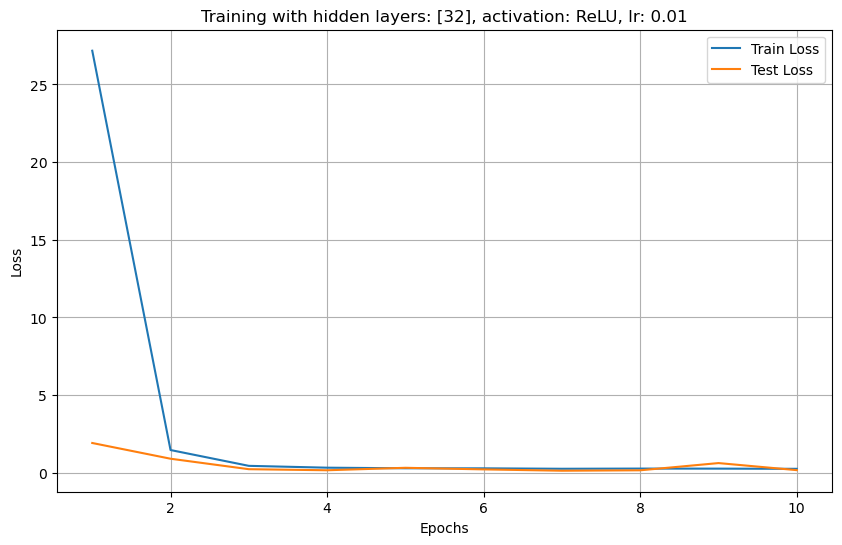

Training with hidden layers: [32], activation: ReLU, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:02<00:00, 924.66it/s]


Epoch [1/10], Train Loss: 130.9422, Test Loss: 50.6066


Epoch 2/10: 100%|██████████| 2500/2500 [00:02<00:00, 933.66it/s]


Epoch [2/10], Train Loss: 26.6075, Test Loss: 12.8282


Epoch 3/10: 100%|██████████| 2500/2500 [00:02<00:00, 924.63it/s]


Epoch [3/10], Train Loss: 9.2468, Test Loss: 6.1005


Epoch 4/10: 100%|██████████| 2500/2500 [00:02<00:00, 857.87it/s]


Epoch [4/10], Train Loss: 4.8036, Test Loss: 3.5270


Epoch 5/10: 100%|██████████| 2500/2500 [00:02<00:00, 902.55it/s]


Epoch [5/10], Train Loss: 3.0077, Test Loss: 2.3975


Epoch 6/10: 100%|██████████| 2500/2500 [00:02<00:00, 919.18it/s]


Epoch [6/10], Train Loss: 2.1965, Test Loss: 2.0405


Epoch 7/10: 100%|██████████| 2500/2500 [00:02<00:00, 907.99it/s]


Epoch [7/10], Train Loss: 1.8729, Test Loss: 1.6585


Epoch 8/10: 100%|██████████| 2500/2500 [00:02<00:00, 914.53it/s]


Epoch [8/10], Train Loss: 1.4571, Test Loss: 1.2014


Epoch 9/10: 100%|██████████| 2500/2500 [00:02<00:00, 910.78it/s]


Epoch [9/10], Train Loss: 1.0835, Test Loss: 0.9668


Epoch 10/10: 100%|██████████| 2500/2500 [00:02<00:00, 885.40it/s]


Epoch [10/10], Train Loss: 0.9307, Test Loss: 0.9469


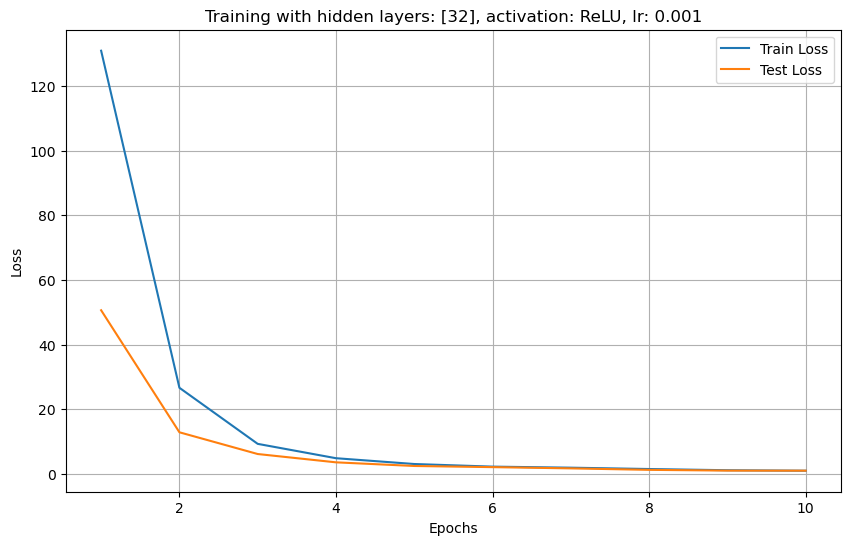

Training with hidden layers: [32], activation: Sigmoid, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:02<00:00, 931.57it/s]


Epoch [1/10], Train Loss: 78.1716, Test Loss: 5.1886


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 790.41it/s]


Epoch [2/10], Train Loss: 3.1724, Test Loss: 1.6226


Epoch 3/10: 100%|██████████| 2500/2500 [00:02<00:00, 843.25it/s]


Epoch [3/10], Train Loss: 1.2273, Test Loss: 0.6610


Epoch 4/10: 100%|██████████| 2500/2500 [00:02<00:00, 907.22it/s]


Epoch [4/10], Train Loss: 0.6258, Test Loss: 0.5825


Epoch 5/10: 100%|██████████| 2500/2500 [00:02<00:00, 917.76it/s]


Epoch [5/10], Train Loss: 0.4730, Test Loss: 0.4299


Epoch 6/10: 100%|██████████| 2500/2500 [00:02<00:00, 901.70it/s]


Epoch [6/10], Train Loss: 0.4084, Test Loss: 0.4200


Epoch 7/10: 100%|██████████| 2500/2500 [00:02<00:00, 917.97it/s]


Epoch [7/10], Train Loss: 0.3745, Test Loss: 0.2440


Epoch 8/10: 100%|██████████| 2500/2500 [00:02<00:00, 924.06it/s]


Epoch [8/10], Train Loss: 0.3053, Test Loss: 0.7002


Epoch 9/10: 100%|██████████| 2500/2500 [00:02<00:00, 872.39it/s]


Epoch [9/10], Train Loss: 0.3003, Test Loss: 0.1799


Epoch 10/10: 100%|██████████| 2500/2500 [00:02<00:00, 851.24it/s]


Epoch [10/10], Train Loss: 0.2582, Test Loss: 0.1767


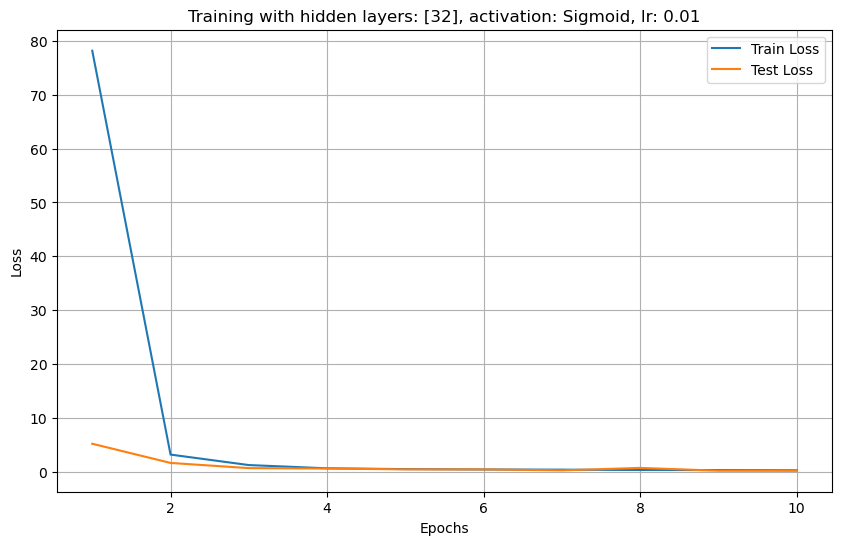

Training with hidden layers: [32], activation: Sigmoid, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:02<00:00, 906.17it/s]


Epoch [1/10], Train Loss: 425.0263, Test Loss: 163.8040


Epoch 2/10: 100%|██████████| 2500/2500 [00:02<00:00, 899.05it/s]


Epoch [2/10], Train Loss: 104.6134, Test Loss: 65.3204


Epoch 3/10: 100%|██████████| 2500/2500 [00:02<00:00, 880.37it/s]


Epoch [3/10], Train Loss: 58.7589, Test Loss: 51.6367


Epoch 4/10: 100%|██████████| 2500/2500 [00:02<00:00, 874.38it/s]


Epoch [4/10], Train Loss: 36.0505, Test Loss: 17.5075


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 806.11it/s]


Epoch [5/10], Train Loss: 11.1271, Test Loss: 6.1454


Epoch 6/10: 100%|██████████| 2500/2500 [00:02<00:00, 844.06it/s]


Epoch [6/10], Train Loss: 4.8860, Test Loss: 3.9200


Epoch 7/10: 100%|██████████| 2500/2500 [00:02<00:00, 899.67it/s]


Epoch [7/10], Train Loss: 3.4573, Test Loss: 3.0700


Epoch 8/10: 100%|██████████| 2500/2500 [00:02<00:00, 906.84it/s]


Epoch [8/10], Train Loss: 2.9155, Test Loss: 2.7140


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 822.46it/s]


Epoch [9/10], Train Loss: 2.6151, Test Loss: 2.4266


Epoch 10/10: 100%|██████████| 2500/2500 [00:02<00:00, 891.20it/s]


Epoch [10/10], Train Loss: 2.3793, Test Loss: 2.2949


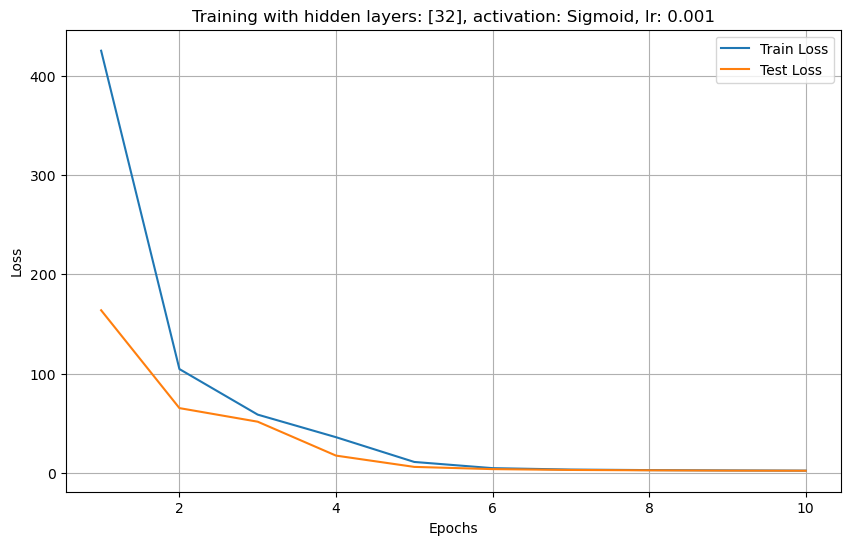

Training with hidden layers: [32], activation: Tanh, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:02<00:00, 894.17it/s]


Epoch [1/10], Train Loss: 61.4922, Test Loss: 4.8234


Epoch 2/10: 100%|██████████| 2500/2500 [00:02<00:00, 901.33it/s]


Epoch [2/10], Train Loss: 1.8512, Test Loss: 1.3175


Epoch 3/10: 100%|██████████| 2500/2500 [00:02<00:00, 910.55it/s]


Epoch [3/10], Train Loss: 0.9874, Test Loss: 1.0719


Epoch 4/10: 100%|██████████| 2500/2500 [00:02<00:00, 896.32it/s]


Epoch [4/10], Train Loss: 0.9757, Test Loss: 0.8414


Epoch 5/10: 100%|██████████| 2500/2500 [00:02<00:00, 916.70it/s]


Epoch [5/10], Train Loss: 0.8424, Test Loss: 0.7270


Epoch 6/10: 100%|██████████| 2500/2500 [00:02<00:00, 871.09it/s]


Epoch [6/10], Train Loss: 0.8397, Test Loss: 1.4171


Epoch 7/10: 100%|██████████| 2500/2500 [00:02<00:00, 899.59it/s]


Epoch [7/10], Train Loss: 0.8261, Test Loss: 1.0381


Epoch 8/10: 100%|██████████| 2500/2500 [00:02<00:00, 893.76it/s]


Epoch [8/10], Train Loss: 0.7726, Test Loss: 0.5142


Epoch 9/10: 100%|██████████| 2500/2500 [00:02<00:00, 890.05it/s]


Epoch [9/10], Train Loss: 0.6623, Test Loss: 0.5875


Epoch 10/10: 100%|██████████| 2500/2500 [00:02<00:00, 882.71it/s]


Epoch [10/10], Train Loss: 0.6304, Test Loss: 0.8202


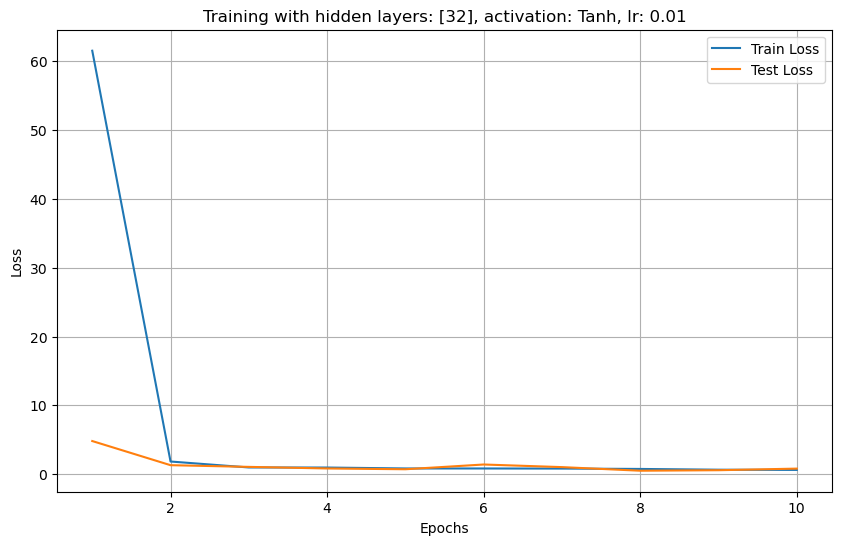

Training with hidden layers: [32], activation: Tanh, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:02<00:00, 848.10it/s]


Epoch [1/10], Train Loss: 378.1389, Test Loss: 108.4228


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 793.12it/s]


Epoch [2/10], Train Loss: 79.1284, Test Loss: 54.7864


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 795.86it/s]


Epoch [3/10], Train Loss: 31.1908, Test Loss: 14.6593


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 818.11it/s]


Epoch [4/10], Train Loss: 10.1210, Test Loss: 6.6967


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 813.08it/s]


Epoch [5/10], Train Loss: 5.0232, Test Loss: 3.9740


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 802.51it/s]


Epoch [6/10], Train Loss: 3.2691, Test Loss: 2.4955


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 798.38it/s]


Epoch [7/10], Train Loss: 2.2224, Test Loss: 1.7564


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 786.97it/s]


Epoch [8/10], Train Loss: 1.5098, Test Loss: 1.2527


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 758.86it/s]


Epoch [9/10], Train Loss: 1.0618, Test Loss: 0.8677


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 782.81it/s]


Epoch [10/10], Train Loss: 0.7503, Test Loss: 0.5579


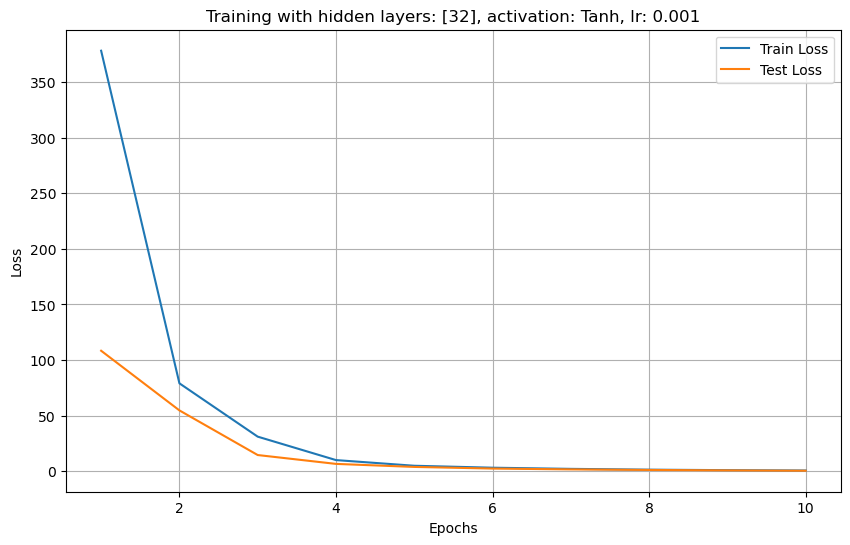

Training with hidden layers: [64], activation: ReLU, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 731.14it/s]


Epoch [1/10], Train Loss: 18.6570, Test Loss: 2.7479


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 768.93it/s]


Epoch [2/10], Train Loss: 1.5093, Test Loss: 0.9289


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 761.54it/s]


Epoch [3/10], Train Loss: 0.9479, Test Loss: 0.4481


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 767.45it/s]


Epoch [4/10], Train Loss: 0.3534, Test Loss: 0.2222


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 755.48it/s]


Epoch [5/10], Train Loss: 0.2773, Test Loss: 0.3672


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 701.18it/s]


Epoch [6/10], Train Loss: 0.3352, Test Loss: 0.2165


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 773.99it/s]


Epoch [7/10], Train Loss: 0.2610, Test Loss: 0.4146


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 740.67it/s]


Epoch [8/10], Train Loss: 0.2774, Test Loss: 0.1206


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 721.16it/s]


Epoch [9/10], Train Loss: 0.2855, Test Loss: 0.1261


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 730.63it/s]


Epoch [10/10], Train Loss: 0.2520, Test Loss: 0.7198


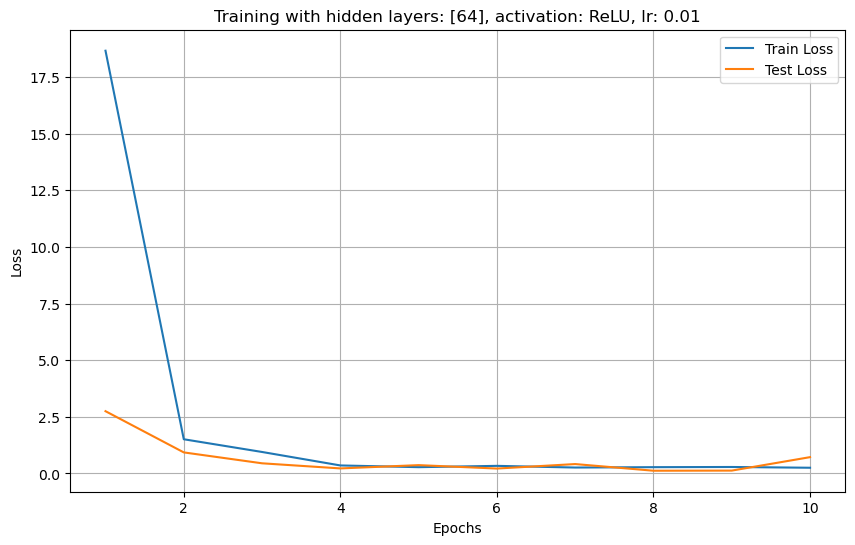

Training with hidden layers: [64], activation: ReLU, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 752.23it/s]


Epoch [1/10], Train Loss: 118.5999, Test Loss: 26.0292


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 760.36it/s]


Epoch [2/10], Train Loss: 14.7407, Test Loss: 6.9081


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 755.77it/s]


Epoch [3/10], Train Loss: 5.1422, Test Loss: 3.4289


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 750.16it/s]


Epoch [4/10], Train Loss: 2.8081, Test Loss: 2.0865


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 760.92it/s]


Epoch [5/10], Train Loss: 1.6573, Test Loss: 1.2642


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 757.99it/s]


Epoch [6/10], Train Loss: 0.8152, Test Loss: 0.5429


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 760.07it/s]


Epoch [7/10], Train Loss: 0.4935, Test Loss: 0.4614


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 750.33it/s]


Epoch [8/10], Train Loss: 0.3521, Test Loss: 0.3097


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 759.07it/s]


Epoch [9/10], Train Loss: 0.2810, Test Loss: 0.2401


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 754.76it/s]


Epoch [10/10], Train Loss: 0.2316, Test Loss: 0.2133


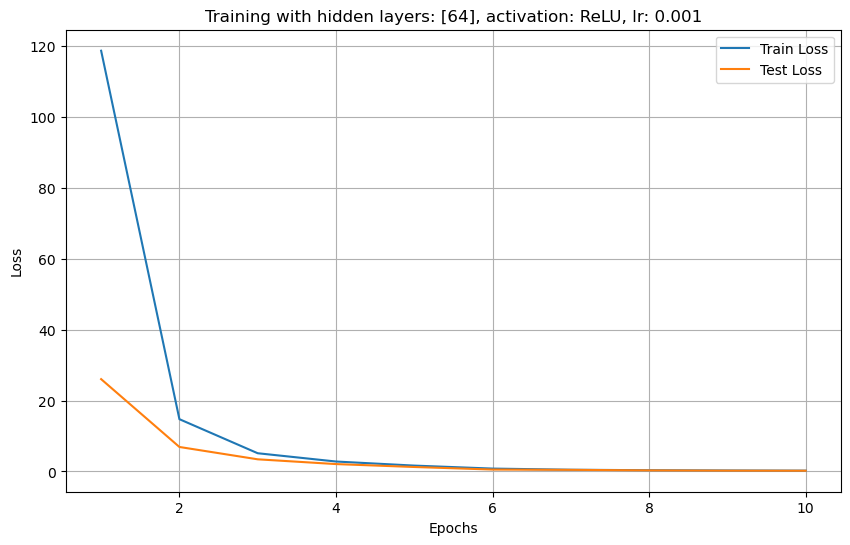

Training with hidden layers: [64], activation: Sigmoid, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 762.12it/s]


Epoch [1/10], Train Loss: 59.2871, Test Loss: 4.0973


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 735.11it/s]


Epoch [2/10], Train Loss: 2.7965, Test Loss: 1.5691


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 752.64it/s]


Epoch [3/10], Train Loss: 1.0322, Test Loss: 0.4229


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 761.21it/s]


Epoch [4/10], Train Loss: 0.3715, Test Loss: 0.2776


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 760.00it/s]


Epoch [5/10], Train Loss: 0.2472, Test Loss: 0.1789


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 743.78it/s]


Epoch [6/10], Train Loss: 0.2132, Test Loss: 0.0942


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 765.73it/s]


Epoch [7/10], Train Loss: 0.2150, Test Loss: 0.1567


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 768.80it/s]


Epoch [8/10], Train Loss: 0.1948, Test Loss: 0.3256


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 759.65it/s]


Epoch [9/10], Train Loss: 0.1678, Test Loss: 0.0687


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 758.65it/s]


Epoch [10/10], Train Loss: 0.1706, Test Loss: 0.2219


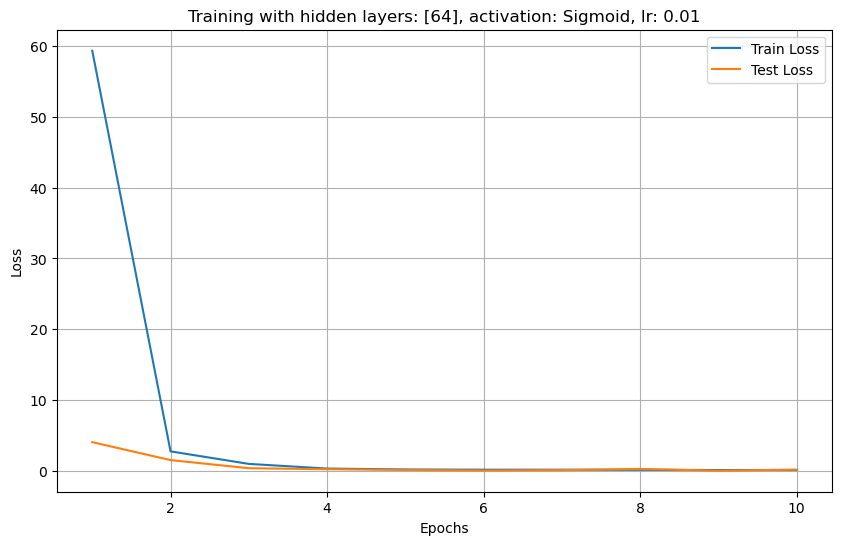

Training with hidden layers: [64], activation: Sigmoid, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 775.00it/s]


Epoch [1/10], Train Loss: 311.1943, Test Loss: 129.1342


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 758.44it/s]


Epoch [2/10], Train Loss: 81.0645, Test Loss: 53.8567


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 765.01it/s]


Epoch [3/10], Train Loss: 35.2214, Test Loss: 16.3150


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 770.46it/s]


Epoch [4/10], Train Loss: 9.3506, Test Loss: 4.5262


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 733.27it/s]


Epoch [5/10], Train Loss: 3.6083, Test Loss: 2.9205


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 759.36it/s]


Epoch [6/10], Train Loss: 2.6811, Test Loss: 2.3345


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 768.38it/s]


Epoch [7/10], Train Loss: 2.2349, Test Loss: 2.1846


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 757.93it/s]


Epoch [8/10], Train Loss: 1.9440, Test Loss: 1.7429


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 769.04it/s]


Epoch [9/10], Train Loss: 1.6797, Test Loss: 1.5646


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 772.35it/s]


Epoch [10/10], Train Loss: 1.4573, Test Loss: 1.3068


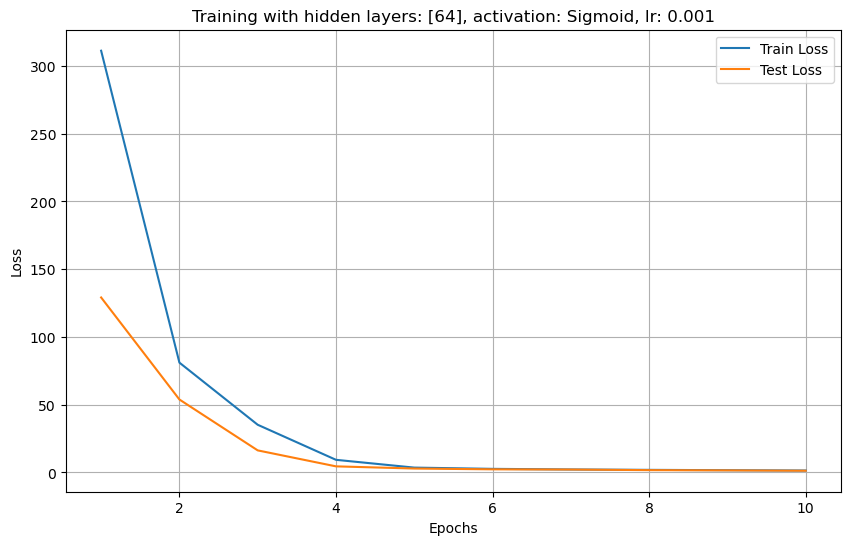

Training with hidden layers: [64], activation: Tanh, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 759.74it/s]


Epoch [1/10], Train Loss: 41.6805, Test Loss: 2.7766


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 768.20it/s]


Epoch [2/10], Train Loss: 1.7836, Test Loss: 0.6567


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 755.15it/s]


Epoch [3/10], Train Loss: 0.5327, Test Loss: 0.9261


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 754.67it/s]


Epoch [4/10], Train Loss: 0.4107, Test Loss: 0.3082


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 714.11it/s]


Epoch [5/10], Train Loss: 0.3812, Test Loss: 0.6632


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 771.30it/s]


Epoch [6/10], Train Loss: 0.3117, Test Loss: 0.1508


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 756.13it/s]


Epoch [7/10], Train Loss: 0.3757, Test Loss: 0.2532


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 725.31it/s]


Epoch [8/10], Train Loss: 0.3028, Test Loss: 0.5327


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 767.50it/s]


Epoch [9/10], Train Loss: 0.3529, Test Loss: 0.0917


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 747.43it/s]


Epoch [10/10], Train Loss: 0.2553, Test Loss: 0.1146


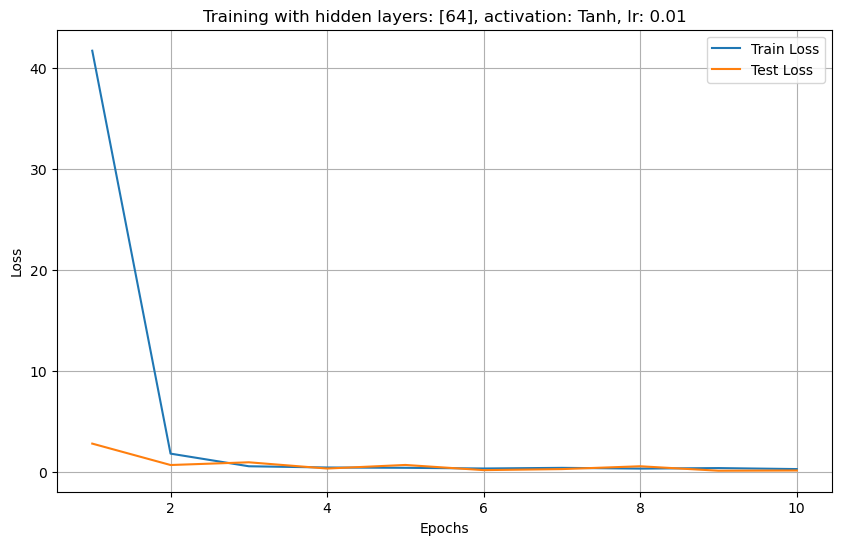

Training with hidden layers: [64], activation: Tanh, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 771.85it/s]


Epoch [1/10], Train Loss: 247.9494, Test Loss: 74.9287


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 769.49it/s]


Epoch [2/10], Train Loss: 53.6389, Test Loss: 26.3875


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 769.52it/s]


Epoch [3/10], Train Loss: 15.3782, Test Loss: 7.6326


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 773.09it/s]


Epoch [4/10], Train Loss: 5.4229, Test Loss: 3.8392


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 772.35it/s]


Epoch [5/10], Train Loss: 3.3049, Test Loss: 2.7633


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 764.34it/s]


Epoch [6/10], Train Loss: 2.1696, Test Loss: 1.5306


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 766.11it/s]


Epoch [7/10], Train Loss: 1.2422, Test Loss: 0.9487


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 715.54it/s]


Epoch [8/10], Train Loss: 0.6845, Test Loss: 0.5107


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 716.06it/s]


Epoch [9/10], Train Loss: 0.4343, Test Loss: 0.3375


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 748.77it/s]


Epoch [10/10], Train Loss: 0.3184, Test Loss: 0.3424


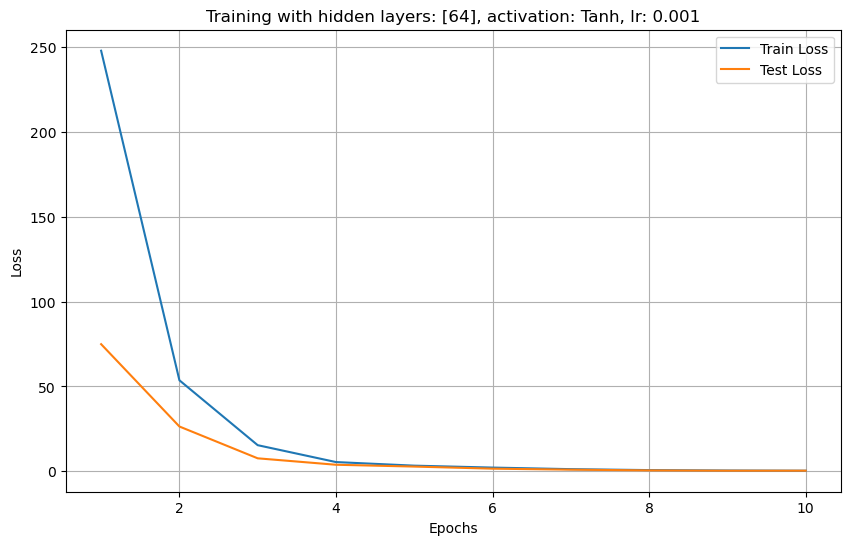

Training with hidden layers: [32, 16], activation: ReLU, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:04<00:00, 623.68it/s]


Epoch [1/10], Train Loss: 20.0677, Test Loss: 2.6607


Epoch 2/10: 100%|██████████| 2500/2500 [00:04<00:00, 622.12it/s]


Epoch [2/10], Train Loss: 1.1288, Test Loss: 0.9980


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 635.67it/s]


Epoch [3/10], Train Loss: 0.6258, Test Loss: 0.3556


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 628.70it/s]


Epoch [4/10], Train Loss: 0.5829, Test Loss: 4.4028


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 631.18it/s]


Epoch [5/10], Train Loss: 0.5067, Test Loss: 0.7126


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 629.96it/s]


Epoch [6/10], Train Loss: 0.4418, Test Loss: 0.2853


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 636.06it/s]


Epoch [7/10], Train Loss: 0.5545, Test Loss: 0.1782


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 632.83it/s]


Epoch [8/10], Train Loss: 0.4035, Test Loss: 0.2886


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 630.05it/s]


Epoch [9/10], Train Loss: 0.4037, Test Loss: 0.2124


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 629.85it/s]


Epoch [10/10], Train Loss: 0.4060, Test Loss: 0.2506


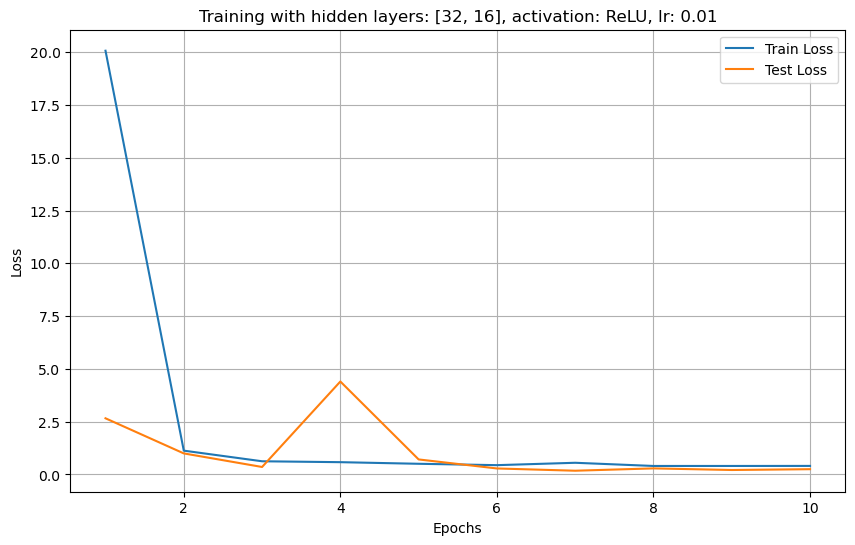

Training with hidden layers: [32, 16], activation: ReLU, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 633.79it/s]


Epoch [1/10], Train Loss: 109.3017, Test Loss: 9.4912


Epoch 2/10: 100%|██████████| 2500/2500 [00:04<00:00, 598.08it/s]


Epoch [2/10], Train Loss: 4.2548, Test Loss: 2.0697


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 626.26it/s]


Epoch [3/10], Train Loss: 1.4777, Test Loss: 1.2406


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 629.28it/s]


Epoch [4/10], Train Loss: 0.9472, Test Loss: 0.7101


Epoch 5/10: 100%|██████████| 2500/2500 [00:04<00:00, 623.91it/s]


Epoch [5/10], Train Loss: 0.7188, Test Loss: 0.5629


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 627.99it/s]


Epoch [6/10], Train Loss: 0.6090, Test Loss: 0.5431


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 636.89it/s]


Epoch [7/10], Train Loss: 0.5754, Test Loss: 0.5083


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 633.73it/s]


Epoch [8/10], Train Loss: 0.5283, Test Loss: 0.4850


Epoch 9/10: 100%|██████████| 2500/2500 [00:04<00:00, 623.89it/s]


Epoch [9/10], Train Loss: 0.4666, Test Loss: 0.4169


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 627.82it/s]


Epoch [10/10], Train Loss: 0.4153, Test Loss: 0.3228


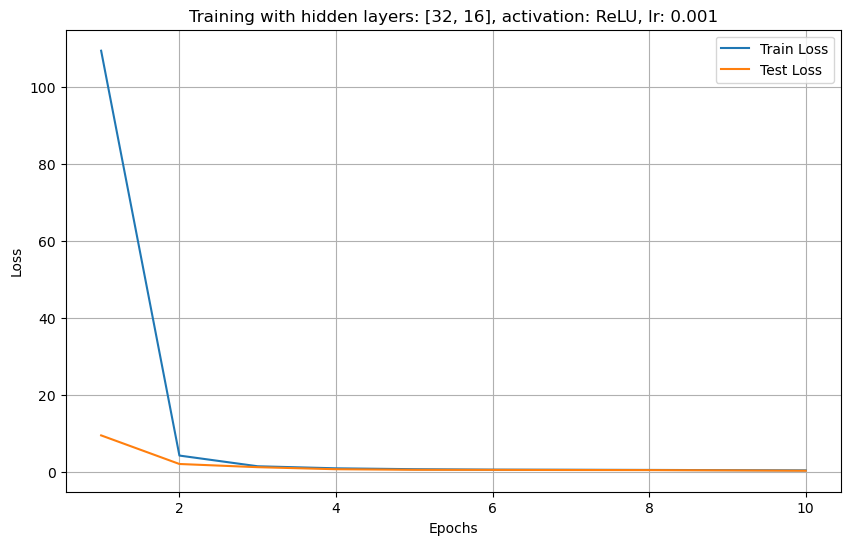

Training with hidden layers: [32, 16], activation: Sigmoid, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 631.38it/s]


Epoch [1/10], Train Loss: 102.7343, Test Loss: 2.9847


Epoch 2/10: 100%|██████████| 2500/2500 [00:04<00:00, 624.67it/s]


Epoch [2/10], Train Loss: 2.1041, Test Loss: 0.9483


Epoch 3/10: 100%|██████████| 2500/2500 [00:04<00:00, 604.52it/s]


Epoch [3/10], Train Loss: 0.8312, Test Loss: 0.3814


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 626.10it/s]


Epoch [4/10], Train Loss: 0.5600, Test Loss: 0.2741


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 631.88it/s]


Epoch [5/10], Train Loss: 0.4380, Test Loss: 0.2638


Epoch 6/10: 100%|██████████| 2500/2500 [00:04<00:00, 614.76it/s]


Epoch [6/10], Train Loss: 0.4381, Test Loss: 0.1236


Epoch 7/10: 100%|██████████| 2500/2500 [00:04<00:00, 617.59it/s]


Epoch [7/10], Train Loss: 0.3906, Test Loss: 0.2449


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 631.80it/s]


Epoch [8/10], Train Loss: 0.3225, Test Loss: 0.1744


Epoch 9/10: 100%|██████████| 2500/2500 [00:04<00:00, 624.15it/s]


Epoch [9/10], Train Loss: 0.2735, Test Loss: 0.2660


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 628.86it/s]


Epoch [10/10], Train Loss: 0.3304, Test Loss: 0.1992


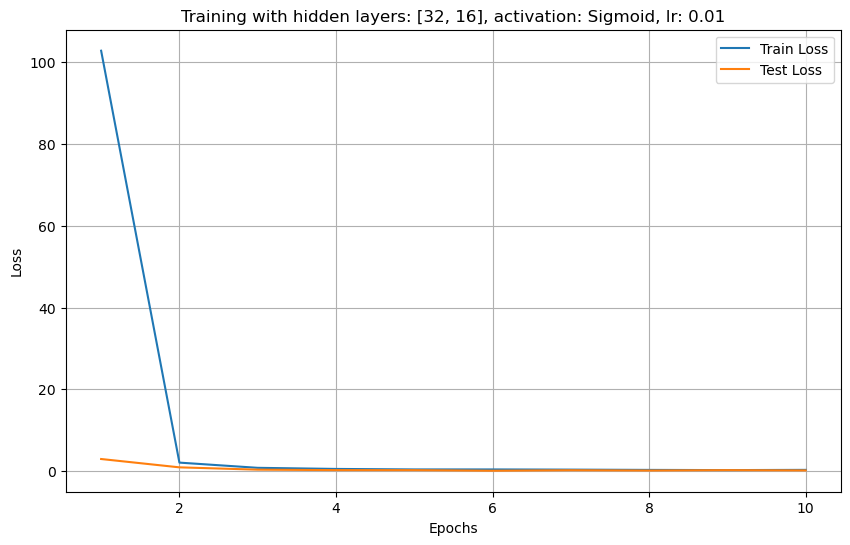

Training with hidden layers: [32, 16], activation: Sigmoid, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 635.80it/s]


Epoch [1/10], Train Loss: 614.7995, Test Loss: 302.6488


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 628.50it/s]


Epoch [2/10], Train Loss: 150.3281, Test Loss: 58.1513


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 638.82it/s]


Epoch [3/10], Train Loss: 33.0601, Test Loss: 14.1993


Epoch 4/10: 100%|██████████| 2500/2500 [00:04<00:00, 609.64it/s]


Epoch [4/10], Train Loss: 9.3500, Test Loss: 4.4208


Epoch 5/10: 100%|██████████| 2500/2500 [00:04<00:00, 623.98it/s]


Epoch [5/10], Train Loss: 3.2810, Test Loss: 1.8365


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 629.01it/s]


Epoch [6/10], Train Loss: 1.5204, Test Loss: 0.9960


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 632.73it/s]


Epoch [7/10], Train Loss: 0.8810, Test Loss: 0.6576


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 633.81it/s]


Epoch [8/10], Train Loss: 0.6202, Test Loss: 0.5782


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 628.67it/s]


Epoch [9/10], Train Loss: 0.4828, Test Loss: 0.4521


Epoch 10/10: 100%|██████████| 2500/2500 [00:04<00:00, 621.03it/s]


Epoch [10/10], Train Loss: 0.3986, Test Loss: 0.3403


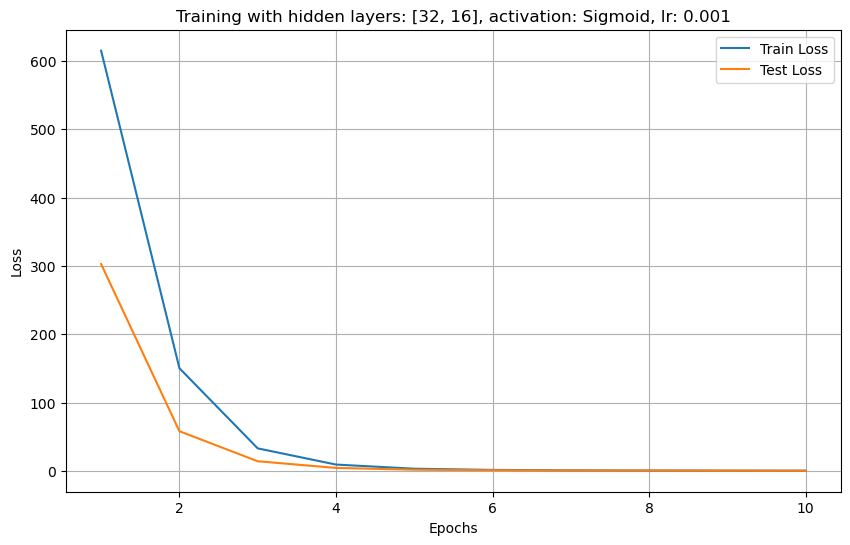

Training with hidden layers: [32, 16], activation: Tanh, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 628.22it/s]


Epoch [1/10], Train Loss: 76.3169, Test Loss: 1.6660


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 630.84it/s]


Epoch [2/10], Train Loss: 1.7952, Test Loss: 6.4049


Epoch 3/10: 100%|██████████| 2500/2500 [00:04<00:00, 623.72it/s]


Epoch [3/10], Train Loss: 1.2442, Test Loss: 0.4696


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 625.98it/s]


Epoch [4/10], Train Loss: 1.0779, Test Loss: 0.5735


Epoch 5/10: 100%|██████████| 2500/2500 [00:04<00:00, 623.22it/s]


Epoch [5/10], Train Loss: 1.3090, Test Loss: 1.9869


Epoch 6/10: 100%|██████████| 2500/2500 [00:04<00:00, 609.78it/s]


Epoch [6/10], Train Loss: 1.0395, Test Loss: 1.0998


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 630.35it/s]


Epoch [7/10], Train Loss: 1.2503, Test Loss: 1.1238


Epoch 8/10: 100%|██████████| 2500/2500 [00:04<00:00, 621.30it/s]


Epoch [8/10], Train Loss: 0.9987, Test Loss: 0.5925


Epoch 9/10: 100%|██████████| 2500/2500 [00:04<00:00, 624.30it/s]


Epoch [9/10], Train Loss: 0.9872, Test Loss: 0.6871


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 625.84it/s]


Epoch [10/10], Train Loss: 0.8647, Test Loss: 0.6610


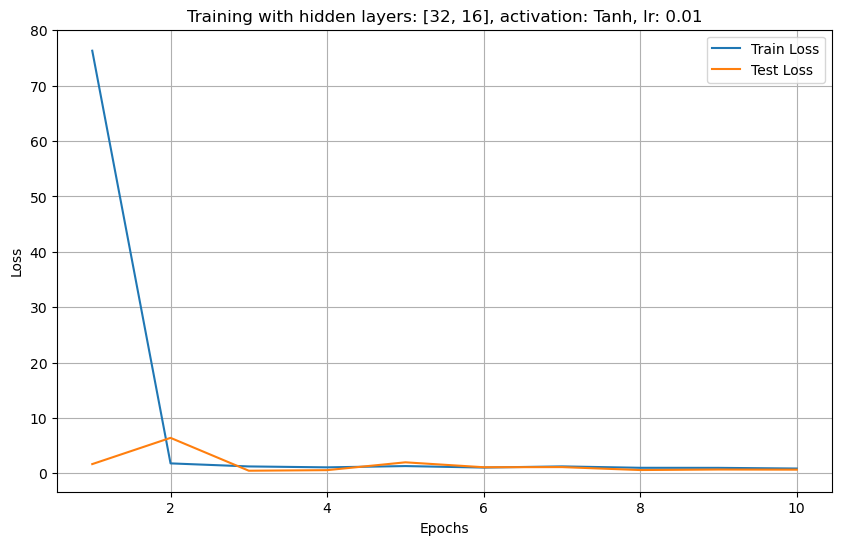

Training with hidden layers: [32, 16], activation: Tanh, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 641.65it/s]


Epoch [1/10], Train Loss: 506.1072, Test Loss: 161.6789


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 630.41it/s]


Epoch [2/10], Train Loss: 85.8116, Test Loss: 32.7149


Epoch 3/10: 100%|██████████| 2500/2500 [00:04<00:00, 619.96it/s]


Epoch [3/10], Train Loss: 19.2216, Test Loss: 7.4092


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 633.55it/s]


Epoch [4/10], Train Loss: 4.5626, Test Loss: 1.8141


Epoch 5/10: 100%|██████████| 2500/2500 [00:04<00:00, 620.48it/s]


Epoch [5/10], Train Loss: 1.2358, Test Loss: 0.8653


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 634.74it/s]


Epoch [6/10], Train Loss: 0.4920, Test Loss: 0.2689


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 628.10it/s]


Epoch [7/10], Train Loss: 0.2886, Test Loss: 0.1835


Epoch 8/10: 100%|██████████| 2500/2500 [00:04<00:00, 606.93it/s]


Epoch [8/10], Train Loss: 0.2078, Test Loss: 0.1286


Epoch 9/10: 100%|██████████| 2500/2500 [00:04<00:00, 620.56it/s]


Epoch [9/10], Train Loss: 0.1651, Test Loss: 0.1070


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 633.07it/s]


Epoch [10/10], Train Loss: 0.1418, Test Loss: 0.1024


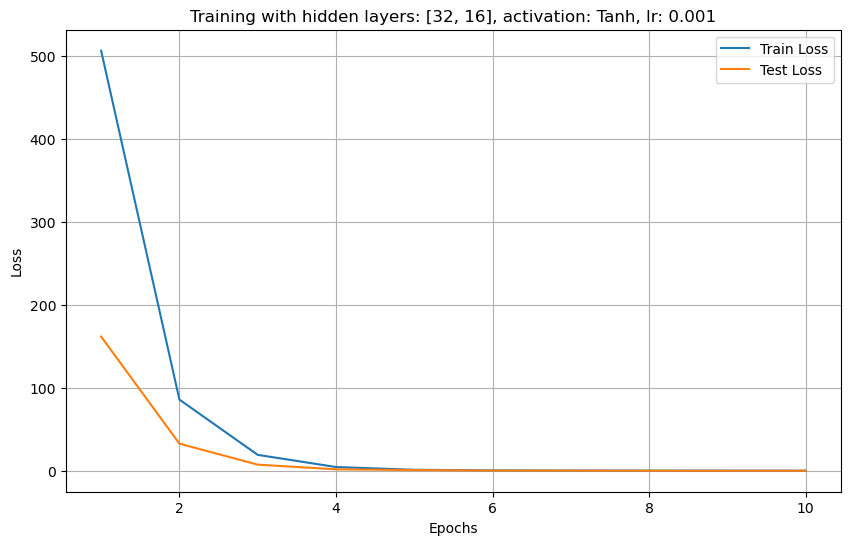

Training with hidden layers: [64, 32], activation: ReLU, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:04<00:00, 612.97it/s]


Epoch [1/10], Train Loss: 13.8553, Test Loss: 1.5165


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 625.22it/s]


Epoch [2/10], Train Loss: 0.8823, Test Loss: 0.3674


Epoch 3/10: 100%|██████████| 2500/2500 [00:04<00:00, 618.09it/s]


Epoch [3/10], Train Loss: 0.8281, Test Loss: 0.2515


Epoch 4/10: 100%|██████████| 2500/2500 [00:04<00:00, 623.19it/s]


Epoch [4/10], Train Loss: 0.6102, Test Loss: 0.2270


Epoch 5/10: 100%|██████████| 2500/2500 [00:04<00:00, 623.52it/s]


Epoch [5/10], Train Loss: 0.5364, Test Loss: 0.4676


Epoch 6/10: 100%|██████████| 2500/2500 [00:04<00:00, 607.36it/s]


Epoch [6/10], Train Loss: 0.6094, Test Loss: 0.2437


Epoch 7/10: 100%|██████████| 2500/2500 [00:04<00:00, 603.87it/s]


Epoch [7/10], Train Loss: 0.4432, Test Loss: 0.3104


Epoch 8/10: 100%|██████████| 2500/2500 [00:04<00:00, 607.90it/s]


Epoch [8/10], Train Loss: 0.3859, Test Loss: 0.1463


Epoch 9/10: 100%|██████████| 2500/2500 [00:04<00:00, 621.95it/s]


Epoch [9/10], Train Loss: 0.4714, Test Loss: 0.1121


Epoch 10/10: 100%|██████████| 2500/2500 [00:04<00:00, 537.33it/s]


Epoch [10/10], Train Loss: 0.3975, Test Loss: 0.1172


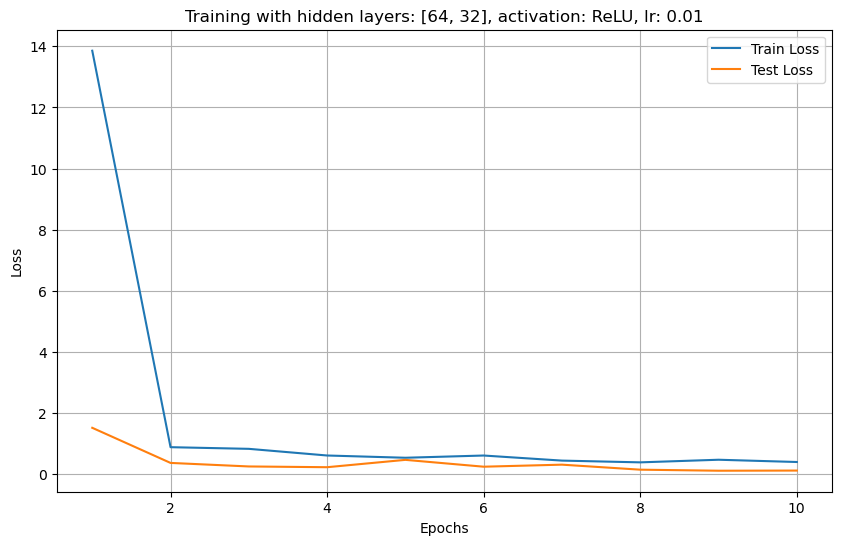

Training with hidden layers: [64, 32], activation: ReLU, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:04<00:00, 621.74it/s]


Epoch [1/10], Train Loss: 55.0724, Test Loss: 3.2496


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 627.35it/s]


Epoch [2/10], Train Loss: 1.8197, Test Loss: 0.8894


Epoch 3/10: 100%|██████████| 2500/2500 [1:00:32<00:00,  1.45s/it]  


Epoch [3/10], Train Loss: 0.5718, Test Loss: 0.3444


Epoch 4/10: 100%|██████████| 2500/2500 [00:04<00:00, 620.31it/s]


Epoch [4/10], Train Loss: 0.3249, Test Loss: 0.4567


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 745.96it/s]


Epoch [5/10], Train Loss: 0.2495, Test Loss: 0.3134


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 745.66it/s]


Epoch [6/10], Train Loss: 0.1980, Test Loss: 0.2441


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 628.09it/s]


Epoch [7/10], Train Loss: 0.1940, Test Loss: 0.1334


Epoch 8/10: 100%|██████████| 2500/2500 [00:04<00:00, 610.98it/s]


Epoch [8/10], Train Loss: 0.1826, Test Loss: 0.1129


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 717.18it/s]


Epoch [9/10], Train Loss: 0.1615, Test Loss: 0.1150


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 677.06it/s]


Epoch [10/10], Train Loss: 0.1658, Test Loss: 0.1292


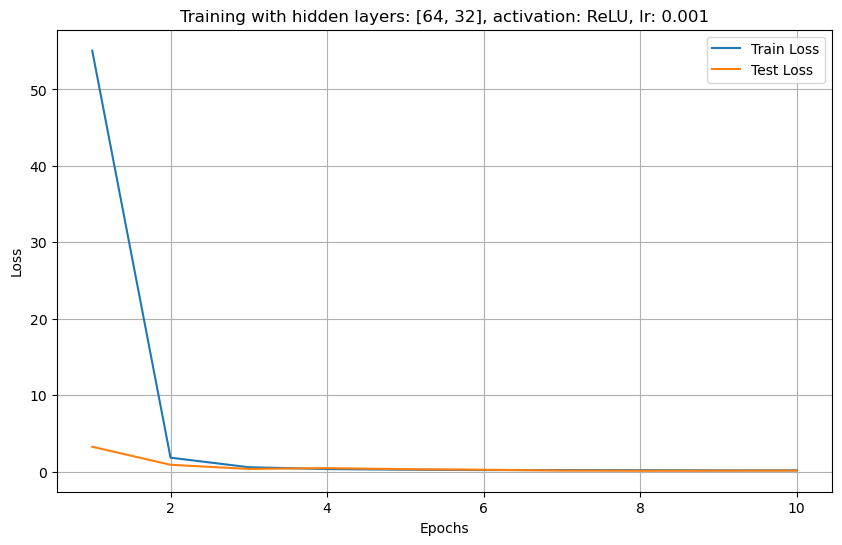

Training with hidden layers: [64, 32], activation: Sigmoid, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 707.12it/s]


Epoch [1/10], Train Loss: 77.5590, Test Loss: 1.8580


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 729.64it/s]


Epoch [2/10], Train Loss: 1.4781, Test Loss: 0.6583


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 755.68it/s]


Epoch [3/10], Train Loss: 0.8822, Test Loss: 0.4818


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 731.23it/s]


Epoch [4/10], Train Loss: 0.7456, Test Loss: 0.3474


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 698.42it/s]


Epoch [5/10], Train Loss: 0.6541, Test Loss: 0.2019


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 679.11it/s]


Epoch [6/10], Train Loss: 0.5149, Test Loss: 0.2467


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 671.07it/s]


Epoch [7/10], Train Loss: 0.5134, Test Loss: 0.2960


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 684.27it/s]


Epoch [8/10], Train Loss: 0.4626, Test Loss: 0.2114


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 715.19it/s]


Epoch [9/10], Train Loss: 0.4838, Test Loss: 0.6081


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 726.02it/s]


Epoch [10/10], Train Loss: 0.5226, Test Loss: 0.4027


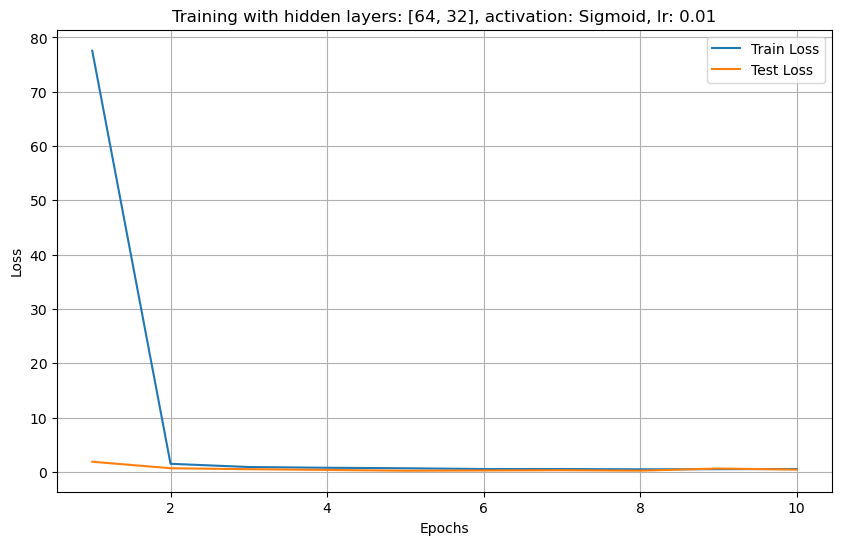

Training with hidden layers: [64, 32], activation: Sigmoid, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 698.65it/s]


Epoch [1/10], Train Loss: 477.0404, Test Loss: 124.6523


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 710.65it/s]


Epoch [2/10], Train Loss: 54.0592, Test Loss: 16.1014


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 668.52it/s]


Epoch [3/10], Train Loss: 9.4696, Test Loss: 4.2973


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 661.75it/s]


Epoch [4/10], Train Loss: 3.0857, Test Loss: 1.7724


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 632.90it/s]


Epoch [5/10], Train Loss: 1.4294, Test Loss: 0.9407


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 671.37it/s]


Epoch [6/10], Train Loss: 0.8514, Test Loss: 0.6915


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 699.81it/s]


Epoch [7/10], Train Loss: 0.5488, Test Loss: 0.4150


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 635.29it/s]


Epoch [8/10], Train Loss: 0.3621, Test Loss: 0.3488


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 659.00it/s]


Epoch [9/10], Train Loss: 0.2594, Test Loss: 0.3270


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 657.04it/s]


Epoch [10/10], Train Loss: 0.1999, Test Loss: 0.1476


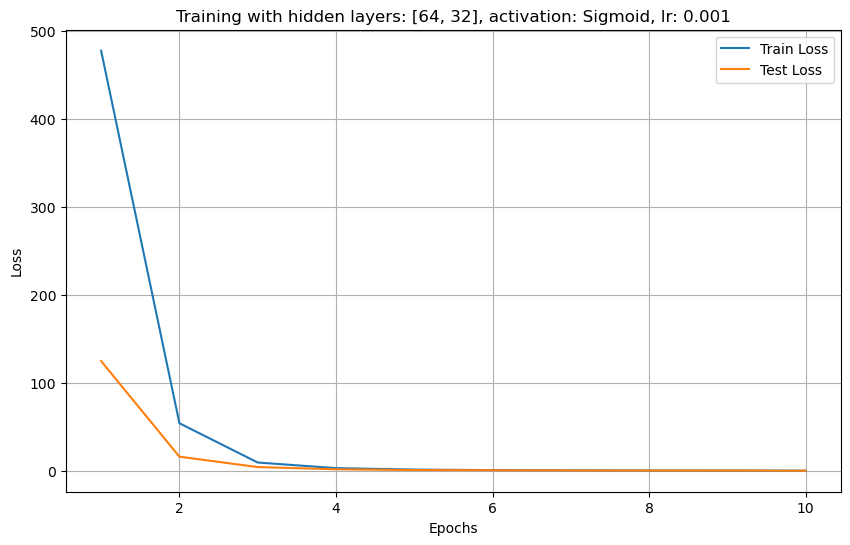

Training with hidden layers: [64, 32], activation: Tanh, lr: 0.01


Epoch 1/10: 100%|██████████| 2500/2500 [00:04<00:00, 616.24it/s]


Epoch [1/10], Train Loss: 46.0876, Test Loss: 0.7900


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 685.93it/s]


Epoch [2/10], Train Loss: 1.8152, Test Loss: 0.7226


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 693.79it/s]


Epoch [3/10], Train Loss: 2.2591, Test Loss: 0.6381


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 676.28it/s]


Epoch [4/10], Train Loss: 1.7640, Test Loss: 0.5601


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 693.22it/s]


Epoch [5/10], Train Loss: 1.6131, Test Loss: 2.2228


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 708.91it/s]


Epoch [6/10], Train Loss: 1.6695, Test Loss: 0.8344


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 666.53it/s]


Epoch [7/10], Train Loss: 1.6000, Test Loss: 0.8175


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 687.40it/s]


Epoch [8/10], Train Loss: 1.3853, Test Loss: 1.3663


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 725.35it/s]


Epoch [9/10], Train Loss: 1.6107, Test Loss: 0.5382


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 762.47it/s]


Epoch [10/10], Train Loss: 1.4207, Test Loss: 1.8963


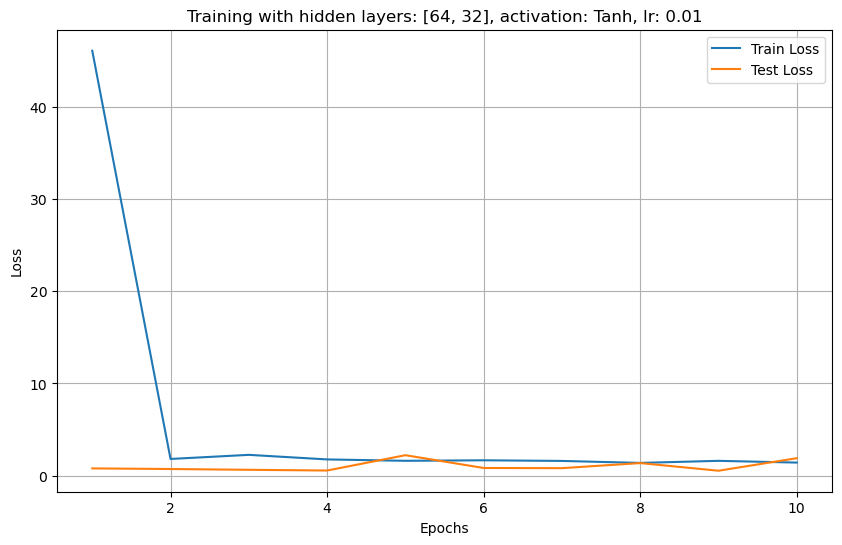

Training with hidden layers: [64, 32], activation: Tanh, lr: 0.001


Epoch 1/10: 100%|██████████| 2500/2500 [00:03<00:00, 767.63it/s]


Epoch [1/10], Train Loss: 293.7229, Test Loss: 43.0858


Epoch 2/10: 100%|██████████| 2500/2500 [00:03<00:00, 769.95it/s]


Epoch [2/10], Train Loss: 20.1780, Test Loss: 6.0744


Epoch 3/10: 100%|██████████| 2500/2500 [00:03<00:00, 757.82it/s]


Epoch [3/10], Train Loss: 3.3085, Test Loss: 1.0994


Epoch 4/10: 100%|██████████| 2500/2500 [00:03<00:00, 743.98it/s]


Epoch [4/10], Train Loss: 0.8221, Test Loss: 0.4641


Epoch 5/10: 100%|██████████| 2500/2500 [00:03<00:00, 714.71it/s]


Epoch [5/10], Train Loss: 0.3893, Test Loss: 0.2992


Epoch 6/10: 100%|██████████| 2500/2500 [00:03<00:00, 738.14it/s]


Epoch [6/10], Train Loss: 0.2869, Test Loss: 0.2062


Epoch 7/10: 100%|██████████| 2500/2500 [00:03<00:00, 755.34it/s]


Epoch [7/10], Train Loss: 0.2480, Test Loss: 0.2268


Epoch 8/10: 100%|██████████| 2500/2500 [00:03<00:00, 769.55it/s]


Epoch [8/10], Train Loss: 0.2300, Test Loss: 0.1968


Epoch 9/10: 100%|██████████| 2500/2500 [00:03<00:00, 769.00it/s]


Epoch [9/10], Train Loss: 0.2125, Test Loss: 0.3043


Epoch 10/10: 100%|██████████| 2500/2500 [00:03<00:00, 742.71it/s]


Epoch [10/10], Train Loss: 0.2093, Test Loss: 0.2036


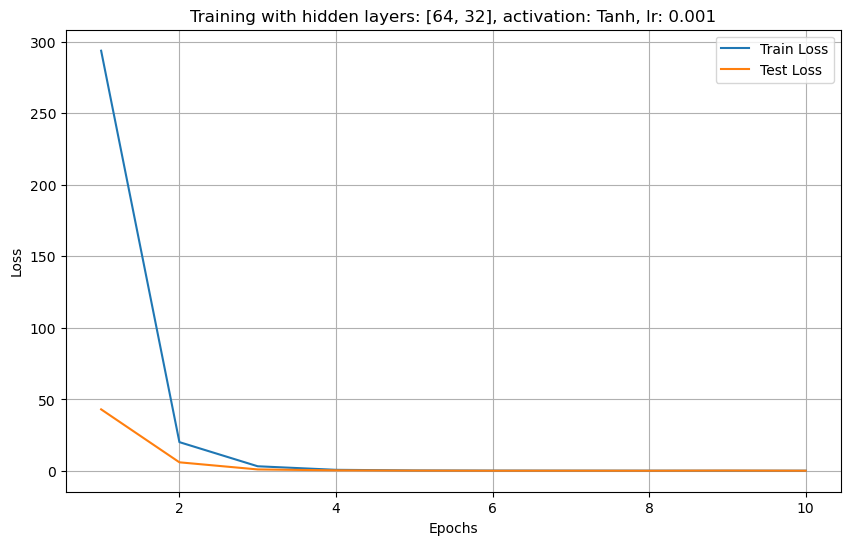

   hidden_layers activation_function  learning_rate  final_train_loss  \
0           [32]                ReLU          0.010          0.258216   
1           [32]                ReLU          0.001          0.930701   
2           [32]             Sigmoid          0.010          0.258167   
3           [32]             Sigmoid          0.001          2.379347   
4           [32]                Tanh          0.010          0.630433   
5           [32]                Tanh          0.001          0.750323   
6           [64]                ReLU          0.010          0.251962   
7           [64]                ReLU          0.001          0.231565   
8           [64]             Sigmoid          0.010          0.170607   
9           [64]             Sigmoid          0.001          1.457277   
10          [64]                Tanh          0.010          0.255265   
11          [64]                Tanh          0.001          0.318410   
12      [32, 16]                ReLU          0.010

In [12]:
import matplotlib.pyplot as plt

# Візуалізація результатів навчання
def plot_training_results(train_loss, test_loss, hidden_layers, activation_function, lr):
    epochs_range = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 6))
    
    # Графік для навчальної втрати (Train Loss)
    plt.plot(epochs_range, train_loss, label='Train Loss')
    
    # Графік для тестової втрати (Test Loss)
    plt.plot(epochs_range, test_loss, label='Test Loss')

    plt.title(f'Training with hidden layers: {hidden_layers}, activation: {activation_function}, lr: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Гіперпараметри для перебору
hidden_layer_options = [[32], [64], [32, 16], [64, 32]]
activation_functions = [nn.ReLU, nn.Sigmoid, nn.Tanh]
learning_rates = [0.01, 0.001]
epochs = 10

results = []

# Основний цикл для перебору гіперпараметрів
for hidden_layers in hidden_layer_options:
    for activation_function in activation_functions:
        for lr in learning_rates:
            print(f"Training with hidden layers: {hidden_layers}, activation: {activation_function.__name__}, lr: {lr}")
            
            # Ініціалізація моделі
            model = NeuralNetwork(input_size=3, hidden_layers=hidden_layers, activation_function=activation_function)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Тренуємо модель
            train_loss, test_loss = train_model(model, optimizer, criterion, train_loader, test_loader, epochs=epochs)
            
            # Зберігаємо результати
            result = {
                'hidden_layers': hidden_layers,
                'activation_function': activation_function.__name__,
                'learning_rate': lr,
                'final_train_loss': train_loss[-1],
                'final_test_loss': test_loss[-1]
            }
            results.append(result)
            
            # Візуалізація тренування
            plot_training_results(train_loss, test_loss, hidden_layers, activation_function.__name__, lr)

# Збір результатів у DataFrame
df_results = pd.DataFrame(results)
print(df_results)

Аналіз та висновки.

In [ ]:
# Аналіз та висновки
best_result = df_results.loc[df_results['final_test_loss'].idxmin()]
print("Найкращі гіперпараметри:")
print(best_result)

# Можна також візуалізувати результати
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for activation in df_results['activation_function'].unique():
    subset = df_results[df_results['activation_function'] == activation]
    plt.plot(subset['learning_rate'], subset['final_test_loss'], label=f'Activation: {activation}')
plt.xlabel('Learning Rate')
plt.ylabel('Final Test Loss')
plt.legend()
plt.show()

Додаткові обчислення. Автоматична модель, яка не має сталого dataset. Приклад.

In [19]:
# Розділяємо дані на тренувальні та тестові
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Перетворюємо дані на тензори
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Створюємо модель персептрону
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(3, 1)  # 3 входи (3 ознаки), 1 вихід (ціль)

    def forward(self, x):
        return self.fc(x)

# Ініціалізуємо модель, функцію втрат і оптимізатор
model = Perceptron()
criterion = nn.MSELoss()  # Функція втрат (середньоквадратична похибка)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Навчання моделі
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Прямий прохід (forward)
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Зворотний прохід (backward)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Оцінка моделі на тестових даних
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch 0, Loss: 1123.6094
Epoch 10, Loss: 111.7504
Epoch 20, Loss: 107.2976
Epoch 30, Loss: 105.5829
Epoch 40, Loss: 103.9867
Epoch 50, Loss: 102.4535
Epoch 60, Loss: 100.9794
Epoch 70, Loss: 99.5621
Epoch 80, Loss: 98.1995
Epoch 90, Loss: 96.8894
Epoch 100, Loss: 95.6298
Epoch 110, Loss: 94.4188
Epoch 120, Loss: 93.2545
Epoch 130, Loss: 92.1351
Epoch 140, Loss: 91.0588
Epoch 150, Loss: 90.0241
Epoch 160, Loss: 89.0292
Epoch 170, Loss: 88.0727
Epoch 180, Loss: 87.1531
Epoch 190, Loss: 86.2690
Epoch 200, Loss: 85.4189
Epoch 210, Loss: 84.6016
Epoch 220, Loss: 83.8158
Epoch 230, Loss: 83.0604
Epoch 240, Loss: 82.3340
Epoch 250, Loss: 81.6357
Epoch 260, Loss: 80.9642
Epoch 270, Loss: 80.3187
Epoch 280, Loss: 79.6981
Epoch 290, Loss: 79.1014
Epoch 300, Loss: 78.5277
Epoch 310, Loss: 77.9761
Epoch 320, Loss: 77.4458
Epoch 330, Loss: 76.9359
Epoch 340, Loss: 76.4457
Epoch 350, Loss: 75.9744
Epoch 360, Loss: 75.5213
Epoch 370, Loss: 75.0856
Epoch 380, Loss: 74.6668
Epoch 390, Loss: 74.2641
Epo

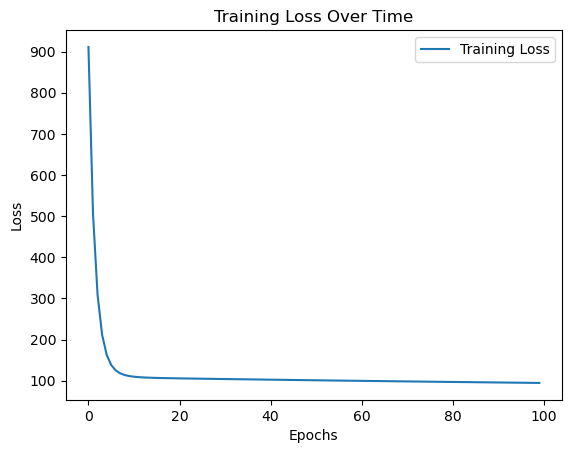

In [11]:
# Побудова графіка функції втрат
plt.plot(range(epochs), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

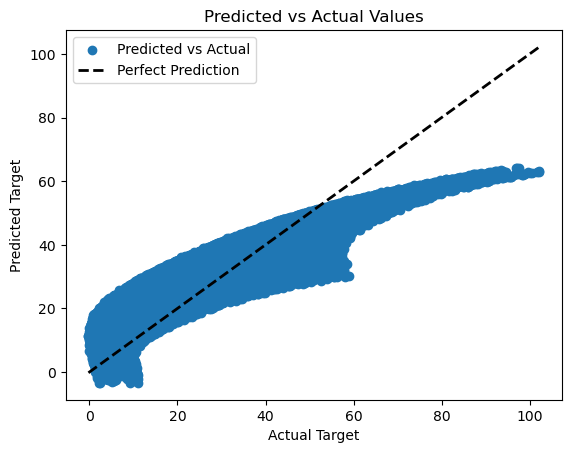

In [12]:
# Оцінка моделі на тестових даних
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    
    # Перетворюємо тензори на numpy масиви для візуалізації
    test_output = test_output.numpy()
    y_test_numpy = y_test_tensor.numpy()

# Побудова графіка передбачень проти фактичних міток
plt.scatter(y_test_numpy, test_output, label='Predicted vs Actual')
plt.plot([y_test_numpy.min(), y_test_numpy.max()], [y_test_numpy.min(), y_test_numpy.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.show()